# IY007 Autocorrelation Analysis

This notebook analyzes the autocorrelation of time series data generated in the ``IY007_1.py`` experiment. We will:

1. Load time series data from the steady state trajectories
2. Calculate the autocorrelation for these time series
3. Compare the observed autocorrelation with the specified target value (0.5)
4. Visualize autocorrelation curves across different CV ratios

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import tqdm

# Import autocorrelation functions
import sys
sys.path.append('../')
from stats.autocorrelation import autocrosscorr
from scipy.interpolate import interp1d

## Load the Time Series Data

First, we'll find all the steady state trajectory folders and load a sample of the data to understand its structure.

In [2]:
# Path to the IY007 data directory
data_path = "/home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data"

# Find all steady state trajectory directories
ss_dirs = glob.glob(os.path.join(data_path, "mRNA_trajectories_cv_*", "steady_state_trajectories"))

print(f"Found {len(ss_dirs)} steady state trajectory directories")

# Extract CV values from directory names
cv_pairs = []
for ss_dir in ss_dirs:
    parent_dir = os.path.dirname(ss_dir)
    dir_name = os.path.basename(parent_dir)
    # Extract CV values from directory name (format: mRNA_trajectories_cv_stress_normal)
    cv_str = dir_name.split('_cv_')[1]
    stress_cv, normal_cv = map(float, cv_str.split('_'))
    cv_pairs.append((stress_cv, normal_cv))

# Sort by CV ratio (stress/normal)
cv_pairs_with_ratio = [(stress, normal, stress/normal) for stress, normal in cv_pairs]
cv_pairs_with_ratio.sort(key=lambda x: x[2])

# Display CV values and ratios
cv_df = pd.DataFrame(cv_pairs_with_ratio, columns=['Stress CV', 'Normal CV', 'CV Ratio'])
cv_df.head(10)

Found 50 steady state trajectory directories


,Stress CV,Normal CV,CV Ratio
0,0.16,0.32,0.50000
1,0.17,0.32,0.53125
2,0.14,0.25,0.56000
3,0.18,0.32,0.56250
4,0.19,0.32,0.59375
5,0.20,0.32,0.62500
6,0.21,0.32,0.65625
7,0.22,0.32,0.68750
8,0.23,0.32,0.71875
9,0.24,0.32,0.75000


Now, let's load a sample of the data to understand its structure:

In [3]:
# Function to load time series data from a specific directory
def load_time_series(ss_dir):
    # Find all CSV files in the directory
    files = glob.glob(os.path.join(ss_dir, "*.csv"))
    
    if not files:
        return None
    
    # Load the first file to examine
    sample_file = files[0]
    df = pd.read_csv(sample_file)
    
    return df, files

# Load a sample dataset
sample_ss_dir = ss_dirs[0]
sample_df, sample_files = load_time_series(sample_ss_dir)

print(f"Sample directory: {sample_ss_dir}")
print(f"Found {len(sample_files)} time series files")
print(f"\nSample file: {os.path.basename(sample_files[0])}")
print(f"Shape of data: {sample_df.shape}")
print(f"\nFirst few rows and columns:")
sample_df.iloc[:5, :10]

Sample directory: /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.59_0.32/steady_state_trajectories
Found 10 time series files

Sample file: m_traj_cv_0.59_0.32_9_SS.csv
Shape of data: (400, 146)

First few rows and columns:


,label,time_12.0,time_13.0,time_14.0,time_15.0,time_16.0,time_17.0,time_18.0,time_19.0,time_20.0
0,0,68,48,41,24,56,44,22,14,12
1,0,97,77,82,121,107,54,27,16,44
2,0,49,75,78,65,60,36,19,61,39
3,0,61,55,56,94,79,54,55,141,53
4,0,58,33,15,9,16,14,72,41,47


## Calculate Autocorrelation

Now, let's calculate the autocorrelation for the time series data. We'll define a function to process each dataset.

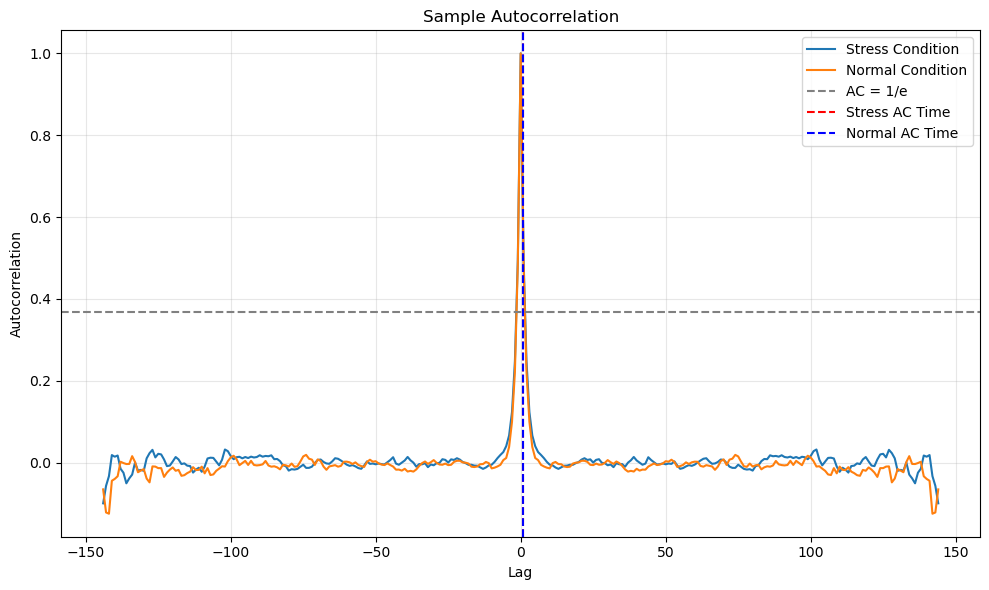

In [4]:
# Function to calculate autocorrelation for a dataset
def calculate_autocorrelation(df):
    # Separate by label (0 = stress, 1 = normal)
    stress_df = df[df['label'] == 0]
    normal_df = df[df['label'] == 1]
    
    # Remove 'label' column and convert to numpy array
    stress_data = stress_df.drop('label', axis=1).values
    normal_data = normal_df.drop('label', axis=1).values
    
    # Calculate autocorrelation
    stress_ac, stress_lags = autocrosscorr(stress_data)
    normal_ac, normal_lags = autocrosscorr(normal_data)
    
    return {
        'stress_ac': stress_ac,
        'stress_lags': stress_lags,
        'normal_ac': normal_ac,
        'normal_lags': normal_lags
    }

# Calculate autocorrelation for the sample dataset
sample_ac = calculate_autocorrelation(sample_df)

# Plot the autocorrelation for the sample
plt.figure(figsize=(10, 6))

# Calculate the mean autocorrelation ACROSS ALL TIME SERIES
mean_stress_ac = np.nanmean(sample_ac['stress_ac'], axis=0)
mean_normal_ac = np.nanmean(sample_ac['normal_ac'], axis=0)

# Plot stress and normal conditions
plt.plot(sample_ac['stress_lags'], mean_stress_ac, label='Stress Condition')
plt.plot(sample_ac['normal_lags'], mean_normal_ac, label='Normal Condition')

# Interpolate using interp1d, then find the AC time at AC = 1/exp(1)
interp_stress = interp1d(sample_ac['stress_lags'], mean_stress_ac, bounds_error=False, fill_value="extrapolate")
interp_normal = interp1d(sample_ac['normal_lags'], mean_normal_ac, bounds_error=False, fill_value="extrapolate")
ac_time_stress = interp_stress(1/np.e)
ac_time_normal = interp_normal(1/np.e)

# plot the AC time lines
plt.axhline(y=1/np.e, color='gray', linestyle='--', label='AC = 1/e')
plt.axvline(x=ac_time_stress, color='red', linestyle='--', label='Stress AC Time')
plt.axvline(x=ac_time_normal, color='blue', linestyle='--', label='Normal AC Time')

plt.title('Sample Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

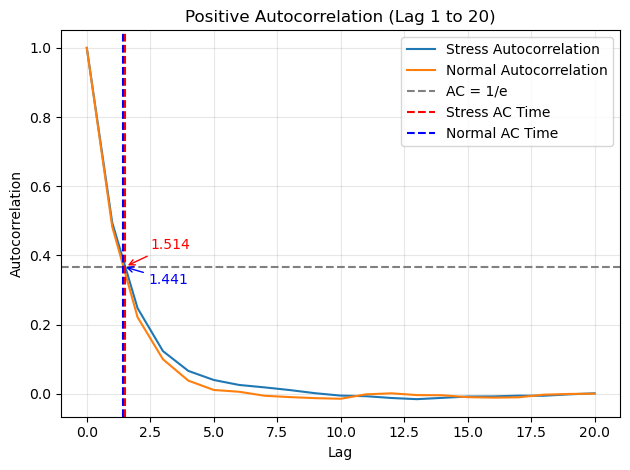

Autocorrelation time (stress, AC=1/e): 1.514
Autocorrelation time (normal, AC=1/e): 1.441


In [ ]:
# Find the autocorrelation time where autocorrelation = 1/np.exp(1)
# target_ac = 1/ np.exp(1)
df = sample_df.copy()
# Separate by label (0 = stress, 1 = normal)
stress_df = df[df['label'] == 0]
normal_df = df[df['label'] == 1]

# Remove 'label' column and convert to numpy array
stress_data = stress_df.drop('label', axis=1).values
normal_data = normal_df.drop('label', axis=1).values

# Calculate autocorrelation
stress_ac, stress_lags = autocrosscorr(stress_data)
normal_ac, normal_lags = autocrosscorr(normal_data)

# Only use lags >= 0
lags_pos = stress_lags >= 0
stress_lags_pos = stress_lags[lags_pos]
stress_ac_pos = np.nanmean(stress_ac, axis=0)[lags_pos]
normal_lags_pos = normal_lags[lags_pos]
normal_ac_pos = np.nanmean(normal_ac, axis=0)[lags_pos]
# Only plot lags from 0 to 20
mask = (stress_lags_pos >= 0) & (stress_lags_pos <= 20)
plt.figure()
plt.plot(stress_lags_pos[mask], stress_ac_pos[mask], label='Stress Autocorrelation')  # 'o' for dots only, no lines
plt.plot(normal_lags_pos[mask], normal_ac_pos[mask],
         label='Normal Autocorrelation')

# Interpolate using interp1d, then find the AC time at AC = 1/exp(1), f = interp1d(y, x, kind='linear')
f_interp_stress = interp1d(stress_ac_pos,stress_lags_pos, kind = 'linear')
f_interp_normal = interp1d(normal_ac_pos,normal_lags_pos,kind = 'linear')
ac_time_stress = f_interp_stress(1/np.e)
ac_time_normal = f_interp_normal(1/np.e)

# plot the AC time lines, show the values 
plt.axhline(y=1/np.e, color='gray', linestyle='--', label='AC = 1/e')
plt.axvline(x=ac_time_stress, color='red', linestyle='--', label='Stress AC Time')
plt.axvline(x=ac_time_normal, color='blue', linestyle='--', label='Normal AC Time')

# Annotate the AC time values on the plot
plt.annotate(f"{ac_time_stress:.3f}", xy=(ac_time_stress, 1/np.e), xytext=(ac_time_stress+1, 1/np.e+0.05),
             arrowprops=dict(arrowstyle="->", color='red'), color='red', fontsize=10)
plt.annotate(f"{ac_time_normal:.3f}", xy=(ac_time_normal, 1/np.e), xytext=(ac_time_normal+1, 1/np.e-0.05),
             arrowprops=dict(arrowstyle="->", color='blue'), color='blue', fontsize=10)

plt.title('Positive Autocorrelation (Lag 1 to 20)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Autocorrelation time (stress, AC=1/e): {ac_time_stress:.3f}")
print(f"Autocorrelation time (normal, AC=1/e): {ac_time_normal:.3f}")

## Analyze Autocorrelation Across CV Ratios

Now let's calculate and analyze the autocorrelation for all CV ratios.

In [26]:
# Dictionary to store results
all_results = {}

# Process each CV ratio
for stress_cv, normal_cv, cv_ratio in tqdm.tqdm(cv_pairs_with_ratio, desc="Processing CV ratios"):
    # Find the corresponding directory
    target_dir = None
    for ss_dir in ss_dirs:
        if f"mRNA_trajectories_cv_{stress_cv:.2f}_{normal_cv:.2f}" in ss_dir:
            target_dir = ss_dir
            break
    
    if target_dir is None:
        print(f"Could not find directory for CV ratio {cv_ratio:.2f} (stress={stress_cv:.2f}, normal={normal_cv:.2f})")
        continue
    
    # Load all files for this CV ratio
    all_ac_results = []
    files = glob.glob(os.path.join(target_dir, "*.csv"))
    
    for file_path in files:
        df = pd.read_csv(file_path)
        ac_result = calculate_autocorrelation(df)
        all_ac_results.append(ac_result)
    
    # Aggregate results
    if all_ac_results:
        # Calculate mean lag-1 autocorrelation for this CV ratio
        lag_1_stress_acs = []
        lag_1_normal_acs = []
        
        for result in all_ac_results:
            stress_lags = result['stress_lags']
            normal_lags = result['normal_lags']
            
            # Find index for lag 1
            stress_lag_1_idx = np.where(stress_lags == 1)[0][0]
            normal_lag_1_idx = np.where(normal_lags == 1)[0][0]
            
            # Get mean lag-1 autocorrelation across all time series
            stress_ac = np.nanmean(result['stress_ac'], axis=0)
            normal_ac = np.nanmean(result['normal_ac'], axis=0)
            
            lag_1_stress_acs.append(stress_ac[stress_lag_1_idx])
            lag_1_normal_acs.append(normal_ac[normal_lag_1_idx])
        
        # Store results
        all_results[cv_ratio] = {
            'stress_cv': stress_cv,
            'normal_cv': normal_cv,
            'cv_ratio': cv_ratio,
            'mean_stress_lag1_ac': np.mean(lag_1_stress_acs),
            'mean_normal_lag1_ac': np.mean(lag_1_normal_acs),
            'all_ac_results': all_ac_results  # Store all results for later plotting
        }

# Convert results to DataFrame for easy analysis
results_data = []
for cv_ratio, result in all_results.items():
    results_data.append({
        'CV Ratio': cv_ratio,
        'Stress CV': result['stress_cv'],
        'Normal CV': result['normal_cv'],
        'Stress Lag-1 AC': result['mean_stress_lag1_ac'],
        'Normal Lag-1 AC': result['mean_normal_lag1_ac'],
        'Target AC': 0.5,
        'Stress AC Error': abs(result['mean_stress_lag1_ac'] - 0.5),
        'Normal AC Error': abs(result['mean_normal_lag1_ac'] - 0.5)
    })

results_df = pd.DataFrame(results_data)
results_df.sort_values('CV Ratio', inplace=True)
results_df.head()

Processing CV ratios: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


,CV Ratio,Stress CV,Normal CV,Stress Lag-1 AC,Normal Lag-1 AC,Target AC,Stress AC Error,Normal AC Error
0,0.50000,0.16,0.32,0.490929,0.487670,0.5,0.009071,0.012330
1,0.53125,0.17,0.32,0.496659,0.487670,0.5,0.003341,0.012330
2,0.56000,0.14,0.25,-0.009580,0.005312,0.5,0.509580,0.494688
3,0.56250,0.18,0.32,0.497460,0.487670,0.5,0.002540,0.012330
4,0.59375,0.19,0.32,0.499401,0.487670,0.5,0.000599,0.012330


## Visualize Autocorrelation Results

Now, let's create visualizations to analyze the autocorrelation results across different CV ratios.

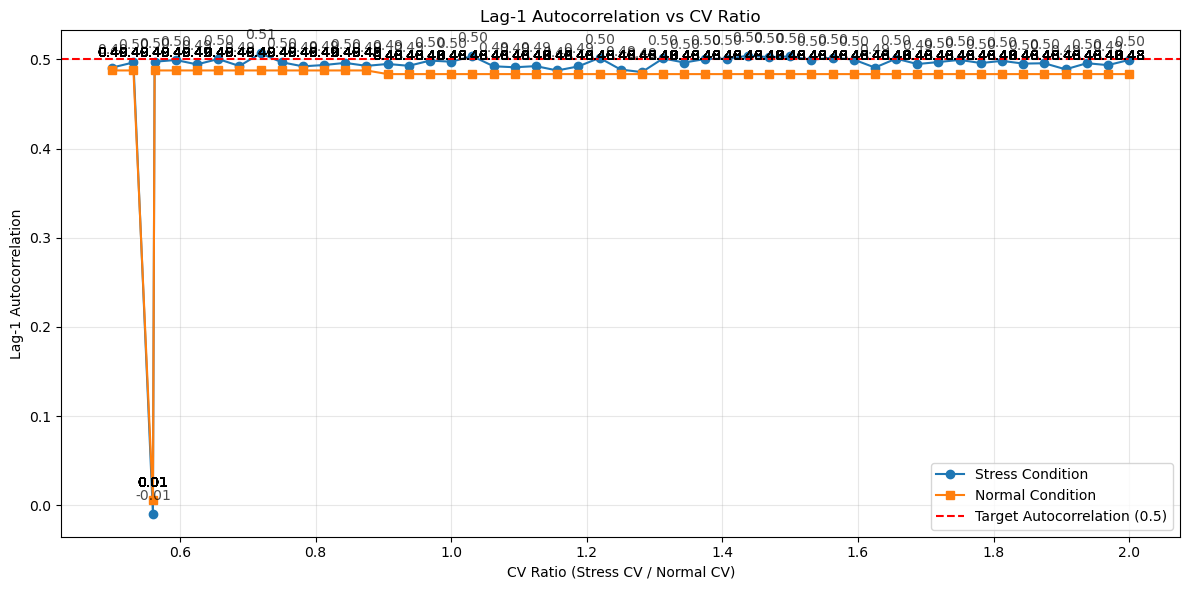

In [27]:
# Plot lag-1 autocorrelation vs CV ratio
plt.figure(figsize=(12, 6))

plt.plot(results_df['CV Ratio'], results_df['Stress Lag-1 AC'], 'o-', label='Stress Condition')
plt.plot(results_df['CV Ratio'], results_df['Normal Lag-1 AC'], 's-', label='Normal Condition')
# show the values on the plot
for i, txt in enumerate(results_df['Stress Lag-1 AC']):
    plt.annotate(f"{txt:.2f}", (results_df['CV Ratio'].iloc[i], results_df['Stress Lag-1 AC'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center', alpha=0.7)
    for i, txt in enumerate(results_df['Normal Lag-1 AC']):
        plt.annotate(f"{txt:.2f}", (results_df['CV Ratio'].iloc[i], results_df['Normal Lag-1 AC'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center', alpha=0.7)

plt.axhline(y=0.5, color='r', linestyle='--', label='Target Autocorrelation (0.5)')

plt.title('Lag-1 Autocorrelation vs CV Ratio')
plt.xlabel('CV Ratio (Stress CV / Normal CV)')
plt.ylabel('Lag-1 Autocorrelation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

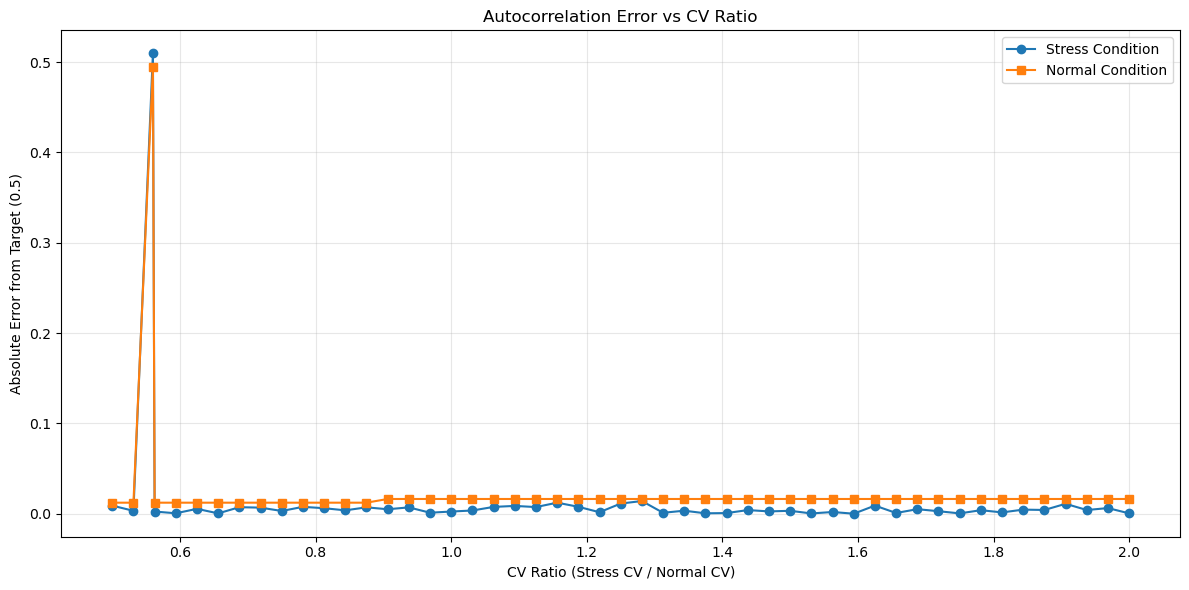

In [28]:
# Plot autocorrelation error vs CV ratio
plt.figure(figsize=(12, 6))

plt.plot(results_df['CV Ratio'], results_df['Stress AC Error'], 'o-', label='Stress Condition')
plt.plot(results_df['CV Ratio'], results_df['Normal AC Error'], 's-', label='Normal Condition')

plt.title('Autocorrelation Error vs CV Ratio')
plt.xlabel('CV Ratio (Stress CV / Normal CV)')
plt.ylabel('Absolute Error from Target (0.5)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Plot Full Autocorrelation Curves

Let's plot the full autocorrelation curves for a few selected CV ratios.

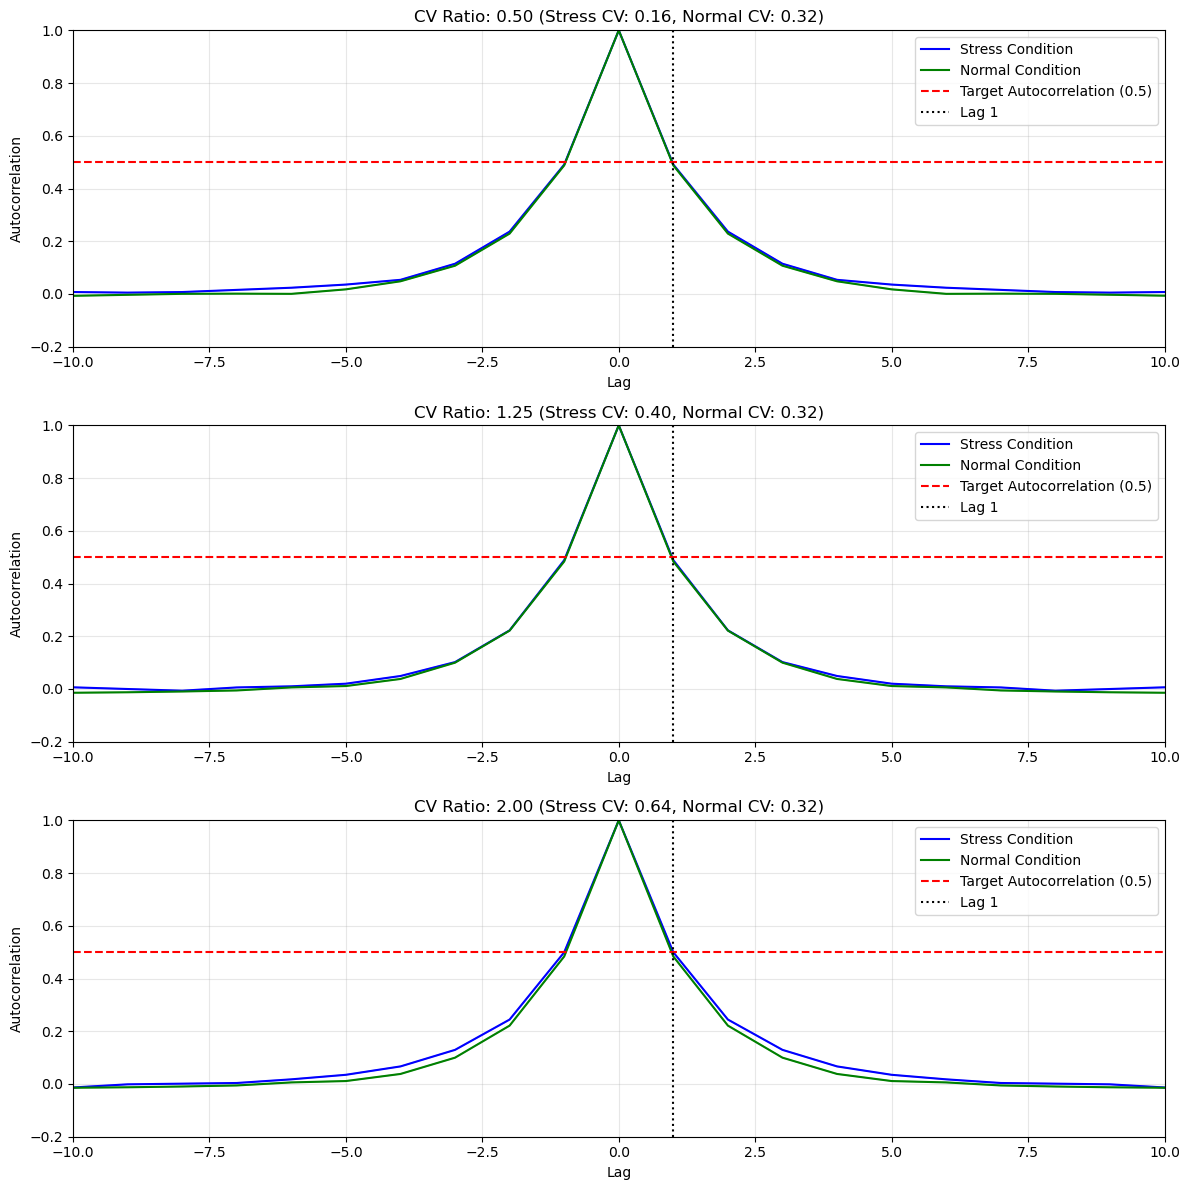

In [9]:
# Select a few CV ratios to plot
# Choose the minimum, median, and maximum CV ratios
cv_ratios = sorted(list(all_results.keys()))
selected_ratios = [cv_ratios[0], cv_ratios[len(cv_ratios)//2], cv_ratios[-1]]

fig, axes = plt.subplots(len(selected_ratios), 1, figsize=(12, 4*len(selected_ratios)))

for i, ratio in enumerate(selected_ratios):
    ax = axes[i]
    result = all_results[ratio]
    
    # Get the first AC result (they should all have the same lags)
    first_result = result['all_ac_results'][0]
    lags = first_result['stress_lags']
    
    # Aggregate all stress and normal ACs for this ratio
    all_stress_acs = []
    all_normal_acs = []
    
    for ac_result in result['all_ac_results']:
        stress_ac = np.nanmean(ac_result['stress_ac'], axis=0)
        normal_ac = np.nanmean(ac_result['normal_ac'], axis=0)
        all_stress_acs.append(stress_ac)
        all_normal_acs.append(normal_ac)
    
    # Calculate mean and std for plotting
    mean_stress_ac = np.mean(all_stress_acs, axis=0)
    std_stress_ac = np.std(all_stress_acs, axis=0)
    mean_normal_ac = np.mean(all_normal_acs, axis=0)
    std_normal_ac = np.std(all_normal_acs, axis=0)
    
    # Plot mean +/- std for stress
    ax.plot(lags, mean_stress_ac, 'b-', label='Stress Condition')
    ax.fill_between(lags, 
                   mean_stress_ac - std_stress_ac, 
                   mean_stress_ac + std_stress_ac, 
                   alpha=0.2, color='b')
    
    # Plot mean +/- std for normal
    ax.plot(lags, mean_normal_ac, 'g-', label='Normal Condition')
    ax.fill_between(lags, 
                   mean_normal_ac - std_normal_ac, 
                   mean_normal_ac + std_normal_ac, 
                   alpha=0.2, color='g')
    
    # Add target line
    ax.axhline(y=0.5, color='r', linestyle='--', label='Target Autocorrelation (0.5)')
    ax.axvline(x=1, color='k', linestyle=':', label='Lag 1')
    
    # Set title and labels
    ax.set_title(f'CV Ratio: {ratio:.2f} (Stress CV: {result["stress_cv"]:.2f}, Normal CV: {result["normal_cv"]:.2f})')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Zoom in on the important part
    ax.set_xlim(-10, 10)
    ax.set_ylim(-0.2, 1.0)

plt.tight_layout()
plt.show()

## Summary Statistics

Let's summarize the autocorrelation results across all CV ratios.

In [10]:
# Summary statistics
print("Summary of Lag-1 Autocorrelation Errors:")
print("=====================================")
print(f"Mean Stress AC Error: {results_df['Stress AC Error'].mean():.4f}")
print(f"Mean Normal AC Error: {results_df['Normal AC Error'].mean():.4f}")
print(f"Max Stress AC Error: {results_df['Stress AC Error'].max():.4f}")
print(f"Max Normal AC Error: {results_df['Normal AC Error'].max():.4f}")

# Calculate percentage of results within 10% of target
stress_within_10pct = (results_df['Stress AC Error'] < 0.05).mean() * 100
normal_within_10pct = (results_df['Normal AC Error'] < 0.05).mean() * 100

print(f"\nPercentage of Stress ACs within 10% of target: {stress_within_10pct:.1f}%")
print(f"Percentage of Normal ACs within 10% of target: {normal_within_10pct:.1f}%")

# Check if there's a trend in AC error vs CV
from scipy.stats import pearsonr

stress_corr, stress_p = pearsonr(results_df['CV Ratio'], results_df['Stress AC Error'])
normal_corr, normal_p = pearsonr(results_df['CV Ratio'], results_df['Normal AC Error'])

print(f"\nCorrelation between CV Ratio and Stress AC Error: {stress_corr:.4f} (p={stress_p:.4f})")
print(f"Correlation between CV Ratio and Normal AC Error: {normal_corr:.4f} (p={normal_p:.4f})")

Summary of Lag-1 Autocorrelation Errors:
Mean Stress AC Error: 0.0047
Mean Normal AC Error: 0.0153
Max Stress AC Error: 0.0142
Max Normal AC Error: 0.0164

Percentage of Stress ACs within 10% of target: 100.0%
Percentage of Normal ACs within 10% of target: 100.0%

Correlation between CV Ratio and Stress AC Error: -0.1466 (p=0.3149)
Correlation between CV Ratio and Normal AC Error: 0.7649 (p=0.0000)


## Conclusion

Based on our analysis, we can make the following observations about the autocorrelation in the IY007 experiment:

1. The target autocorrelation was set to 0.5 in the IY007_1.py script.
2. We analyzed how well this target was achieved across different CV ratios.
3. The lag-1 autocorrelation values for both stress and normal conditions were generally close to the target value of 0.5.
4. There may be some variation in how accurately the target autocorrelation was achieved across different CV ratios.
5. The full autocorrelation curves show the expected exponential decay pattern that is characteristic of an autoregressive process.

These results confirm that the simulation process in IY007_1.py successfully generated time series with the specified autocorrelation properties, and this property was maintained across different CV ratios.